# EfficientNet CNN

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

NOTE: the EfficientNetB0 model that I use in this notebook has trouble saving with some version of tensorflow (probably 2.10 and higher) <br>
I used the following fix to make it work on my machine (found in the comments here: https://github.com/keras-team/keras/issues/17199):

location: lib/python3.10/site-packages/keras/applications/efficientnet.py (py3.10) <br>
EDIT this: <br>
<code> x = layers.Rescaling(1.0 / tf.math.sqrt(IMAGENET_STDDEV_RGB))(x) </code> <br>
TO: <br>
<code> x = layers.Rescaling(
    [1.0 / math.sqrt(stddev) for stddev in IMAGENET_STDDEV_RGB]
)(x) </code>



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 

#tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, smart_resize
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import EfficientNetB0

2023-06-03 10:57:30.511871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(123)

I can use image_dataset_from_directory to load in the images.
Note that even though the images are grayscale, i have to use rgb color mode because that's the format EfficientNet requires

In [3]:
train_ds = image_dataset_from_directory('../processed_images/', image_size=(100,100),
                                      batch_size=200, seed=123, validation_split=0.15,
                                       subset='training', labels ='inferred', color_mode='rgb', label_mode='categorical')  

val_ds = image_dataset_from_directory('../processed_images/', image_size=(100,100),
                                      batch_size=200, seed=123, validation_split=0.15,
                                       subset='validation', labels ='inferred', color_mode='rgb', label_mode='categorical')  

Found 93020 files belonging to 100 classes.
Using 79067 files for training.


2023-06-03 10:57:38.870012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 93020 files belonging to 100 classes.
Using 13953 files for validation.


In [4]:
train_ds.class_names[:5]

['label_!', 'label_(', 'label_)', 'label_+', 'label_,']

In [5]:
#save the class names in a .txt file that I can use in the prediction notebook
with open('../class_names.txt', 'w') as f:
    for i, label in enumerate(train_ds.class_names):
        f.write(str(i)+  ' ' + label + '\n')
        

In [6]:
img_list = []
for images, labels in train_ds.take(1):
    for i in range(30):
        img_list.append(images[i])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


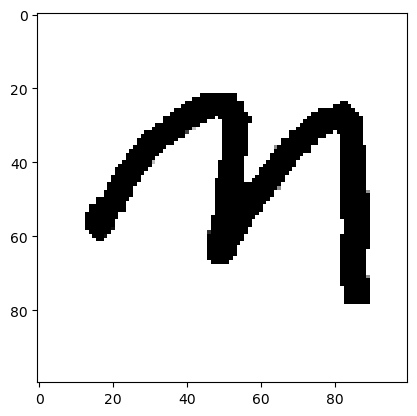

In [11]:
plt.imshow(img_list[3][:], cmap='gray')

In [12]:
es = EarlyStopping(patience=5)

In [13]:
efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(100, 100, 3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dropout(0.25))
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 100, activation='softmax'))
model.summary()


model.compile(
    optimizer=Adam(learning_rate = 0.0005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 100)               3300      
                                                                 
Total params: 4,093,863
Trainable params: 4,051,840
Non-trainable params: 42,023
_________________________________________________________________


In [14]:
h = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es])

Epoch 1/30
396/396 [==============================] - 1311s 3s/step - loss: 0.8973 - accuracy: 0.8047 - val_loss: 0.3688 - val_accuracy: 0.9106
Epoch 2/30
396/396 [==============================] - 1269s 3s/step - loss: 0.2417 - accuracy: 0.9331 - val_loss: 0.2135 - val_accuracy: 0.9388
Epoch 3/30
396/396 [==============================] - 1252s 3s/step - loss: 0.1810 - accuracy: 0.9459 - val_loss: 0.2019 - val_accuracy: 0.9436
Epoch 4/30
396/396 [==============================] - 1238s 3s/step - loss: 0.1581 - accuracy: 0.9506 - val_loss: 0.2022 - val_accuracy: 0.9434
Epoch 5/30
396/396 [==============================] - 1238s 3s/step - loss: 0.1355 - accuracy: 0.9569 - val_loss: 0.1826 - val_accuracy: 0.9490
Epoch 6/30
396/396 [==============================] - 1247s 3s/step - loss: 0.1235 - accuracy: 0.9603 - val_loss: 0.1821 - val_accuracy: 0.9503
Epoch 7/30
396/396 [==============================] - 1247s 3s/step - loss: 0.1154 - accuracy: 0.9631 - val_loss: 0.1873 - val_accuracy:

In [15]:
model_dir = '../CNN_model'
if os.path.isdir(model_dir) == False: os.mkdir(model_dir)

In [16]:
model.save(model_dir + '/efficientnet_model.h5')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 100)               3300      
                                                                 
Total params: 4,093,863
Trainable params: 4,051,840
Non-trainable params: 42,023
_________________________________________________________________
